#GPT

##Set up notebook

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# install necessary packages
!pip install rdkit
!pip install pandas==1.5.3
!pip install molsets
!pip install wandb

# clone Sophia optimizer GitHub repository
!git clone https://github.com/Liuhong99/Sophia.git

# import necessary packages
import numpy as np
import h5py
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, pairwise_distances
import os
import random
from scipy import stats
import matplotlib.pyplot as plt
import pkg_resources
pkg_resources.require("pandas==1.5.3")
import pandas as pd
import re
import math
import random
import logging
import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.cuda.amp import GradScaler
from rdkit import Chem
from rdkit.Chem import QED, Crippen
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
import moses
from moses.utils import get_mol
from Sophia.sophia import SophiaG
import yaml

# set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

MessageError: ignored

##Utils & Dataset

In [ ]:
@torch.no_grad()
def sample(model, x, steps, temperature=1.0, prop=None, scaffold=None):
    block_size = model.get_block_size() # define size of context window used for input conditioning
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # limit conditioning input to the most recent block_size elements
        logits, _= model(x_cond, prop = prop, scaffold = scaffold) # give input to model and get logits (unnormalized scores or probabilities)
        logits = logits[:, -1, :] / temperature # extract the logits for the next token in the sequence
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, 1)
        x = torch.cat((x, ix), dim=1) # concatenate the chosen token index with the existing sequence
    return x

def check_novelty(gen_smiles, train_smiles):
    if len(gen_smiles) == 0:
        novel_ratio = 0
    else:
        duplicates = [1 for mol in gen_smiles if mol in train_smiles]
        novel = len(gen_smiles) - sum(duplicates)
        novel_ratio = novel*100/len(gen_smiles)
    return novel_ratio

def canonic_smiles(smiles_or_mol):
    mol = get_mol(smiles_or_mol)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

class SMILESDataset(Dataset):

    def __init__(self, data=None, content=None, block_size=None, prop = None, scaffold = None, scaffold_maxlen = None, len_data = None):
        if content is None:
            self.desc_only = True
            return
        self.desc_only = False
        chars = sorted(list(set(content)))
        self.vocab_size = len(chars)

        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for i,ch in enumerate(chars)}

        self.max_len = block_size
        self.data = data
        self.prop = prop # define properties to use for conditioning
        self.sca = scaffold # define scaffold to use for conditioning
        self.scaf_max_len = scaffold_maxlen
        self.len_data = len_data

    def export_desc_attributes(self, export_path):
        attr_dict = {
            "desc_only": self.desc_only,
            "vocab_size": self.vocab_size,
            "max_len": self.max_len,
            "stoi": self.stoi,
            "itos": self.itos,
            # "prop": self.prop,
            # "sca": self.sca,
            "scaf_max_len": self.scaf_max_len,
            "len_data": self.len_data
        }
        with open(export_path, 'w') as f:
            yaml.dump(attr_dict, f)

    def load_desc_attributes(self, load_path):
        with open(load_path, 'r') as f:
            attr_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(attr_dict)

    def __len__(self):
        assert not self.desc_only, "Dataset is not initialized"
        return len(self.data)

    def __getitem__(self, idx):
        assert not self.desc_only, "Dataset is not initialized"
        # retrieve SMILES, property, and scaffold information with a given index,
        # remove any leading or trailing whitespaces with .strip() method
        smiles, prop, scaffold = self.data[idx].strip(), self.prop[idx], self.sca[idx]
        if scaffold:
          scaffold=scaffold.strip() # remove any leading or trailing whitespaces
        # define regular expressin pattern used to identify characters in the SMILES strings
        pattern =  "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|!|\*|\$|\%[0-9]{2}|[0-9])"
        regex = re.compile(pattern)
        # pad SMILES string by appending '<' to the end until self.max_len is achieved
        smiles = str('!') + smiles
        smiles += str('<')*(self.max_len - len(regex.findall(smiles)))
        # if the number of matches found by the regular expression pattern applied
        # to the SMILES string exceeds self.max_len:
        if len(regex.findall(smiles)) > self.max_len+1:
            smiles = smiles[:self.max_len+1]
        # find all matches of the regular expression pattern in the SMILES string
        smiles=regex.findall(smiles)
        dix =  [self.stoi[s] for s in smiles]
        if scaffold:
          # pad scaffold string by appending '<' to the end until self.scaf_max_len is achieved
          scaffold += str('<')*(self.scaf_max_len - len(regex.findall(scaffold)))
          if len(regex.findall(scaffold)) > self.scaf_max_len:
              scaffold = scaffold[:self.scaf_max_len]
          scaffold=regex.findall(scaffold) # find all matches of the regular expression pattern in the scaffold string
          # convert each string in scaffold to the corresponding integer
          sca_dix = [self.stoi[s] for s in scaffold]
          # convert scaffold index list to tensor
          sca_tensor = torch.tensor(sca_dix, dtype=torch.long)
        # if scaffold information is not provided:
        else:
          # create boolean tensor representing the absence of scaffold elements
          # to ensure compatibility and consistency with the expected data type
          sca_tensor=torch.tensor(scaffold,dtype=torch.bool)
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        prop = torch.tensor([prop], dtype=torch.float) # create tensor of property value associated with the SMILES
        # return input sequence, target sequence, and associated property value
        return x, y, prop, sca_tensor

##Model

In [ ]:
class GPTConfig:
    def __init__(self, vocab_size=None, block_size=None, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

    def export_attributes(self, export_path):
        with open(export_path, 'w') as f:
            yaml.dump(vars(self), f)

    def load_attributes(self, load_path):
        with open(load_path, 'r') as f:
            config_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(config_dict)

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embed % config.n_head == 0
        self.config = config

        self.query = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.key = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.value = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)

        self.attn_drop = nn.Dropout(config.att_drop_rate)
        self.resid_drop = nn.Dropout(config.att_drop_rate)

        self.proj = nn.Linear(config.n_embed, config.n_embed)
        self.n_head = config.n_head

        num = int(bool(config.num_props)) + int(config.scaffold_maxlen)
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size + num, config.block_size + num))
                                .view(1, 1, config.block_size + num, config.block_size + num))

    def forward(self, x, layer_past=None):
        B, T, C = x.size()
        # apply attention functions to get tensors with dimensions (B, n_head, T, head_size)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head)
        k = self.key(x).view(B, T, self.n_head, C // self.n_head)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head)
        if self.config.do_flash:
            q = q.transpose(1, 2)
            k = k.transpose(1, 2)
            v = v.transpose(1, 2)
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, dropout_p=self.config.att_drop_rate if self.training else 0, is_causal=True)
            y = y.transpose(1, 2)
        else:
            # (B h T s) @ (B h s T) -> (B h T T)
            att = torch.einsum('bths,bihs->bhti', q, k) / math.sqrt(k.size(-1))
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            # (B h T T) @ (B h T s) -> (B h T s)
            y = torch.einsum('bhtq,bqhs->bths', att, v)
            self.att_weights = att
        self.attended = y
        y = y.contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        self.out = y
        return y

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embed)
        self.ln2 = nn.LayerNorm(config.n_embed)
        self.attn = SelfAttention(config)
        self.mlp = nn.Sequential(nn.Linear(config.n_embed, config.ff_mult*config.n_embed), nn.GELU() if config.doGELU else nn.ReLU(),
            nn.Linear(config.ff_mult*config.n_embed, config.n_embed), nn.Dropout(config.att_drop_rate))

    def forward(self, x):
        y = self.attn(self.ln1(x))
        x = x + y # perform a residual connection by summing input and attention output
        x = x + self.mlp(self.ln2(x)) # apply layer normalization and then MLP, create a residual connection with input
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embed)
        self.type_emb = nn.Embedding(2, config.n_embed)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embed))
        # if conditioning on at least 1 property:
        if config.num_props:
            # initialize property linear layer, map property vector to embedding dimension
            self.prop_nn = nn.Linear(config.num_props, config.n_embed)

        self.drop = nn.Dropout(config.gpt_drop_rate)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])

        self.ln_f = nn.LayerNorm(config.n_embed)
        self.head = nn.Linear(config.n_embed, config.vocab_size, bias=config.gpt_bias)
        self.block_size = config.block_size # define the context size
        self.apply(self._init_weights) # initialize weights and apply to all relevant modules in the model

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        decay, no_decay = set(), set()
        no_decay = set()

        whitelist_weight_modules = (torch.nn.Linear)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        # for named module of the model:
        for mn, m in self.named_modules():
            # for named parameter of each module:
            for pn, p in m.named_parameters():
                # construct full parameter name by concatenating module name and parameter name, separated by a dot
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias') or ('bias' in pn):
                    no_decay.add(fpn)
                elif (pn.endswith('weight') or ('weight' in pn)) and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        no_decay.add('pos_emb')
        param_dict = {pn:p for pn, p in self.named_parameters()}
        assert len(decay & no_decay) == 0
        # assert that all parameters from both sets have been correctly separated
        assert len(param_dict.keys() - (decay | no_decay)) == 0
        optim_groups = [{"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}]
        optimizer = SophiaG(optim_groups, lr=train_config.learning_rate, betas=train_config.betas, rho=train_config.rho, weight_decay=train_config.weight_decay)
        return optimizer

    def forward(self, idx, targets=None, prop = None, scaffold = None):
        b, t = idx.size()

        assert t <= self.block_size
        if self.config.num_props: # if conditioning on at least one property:
            assert prop.size(-1) == self.config.num_props, f"number of properties {prop.size(-1)=} doesn't match the expected size {self.config.num_props=}"

        token_embeddings = self.tok_emb(idx) # pass input tensor through token embedding layer
        # select a subset of the position embedding matrix based on the length of the input sequence
        position_embeddings = self.pos_emb[:, :t, :]
        # pass a tensor of ones of shape (b, t) through the type embedding layer,
        # maps a binary type indicator to a learnable embedding vector, all type indicators
        # are set to 1, indicating same type for all tokens in input sequence
        type_embeddings = self.type_emb(torch.ones((b,t), dtype=torch.long, device=idx.device))
        x = self.drop(token_embeddings + position_embeddings + type_embeddings)
        if self.config.num_props:
            type_embd = self.type_emb(torch.zeros((b, 1), dtype=torch.long, device=idx.device)) # create a tensor of size (b, 1, n_embed)
            if prop.ndim == 2: # if there are multiple properties defined for conditioning (dimsnionality=2):
                p = self.prop_nn(prop.unsqueeze(1))
            else:
                p = self.prop_nn(prop)
            p += type_embd # add type embedding tensor element-wise to the property tensor
            x = torch.cat([p, x], 1) # concatenate the property tensor with the input tensor along the second dimension
        if self.config.scaffold:
            # create a tensor of shape (b, 1, n_embed) to contain embeddings for
            # a special type representing the scaffold
            type_embd = self.type_emb(torch.zeros((b, 1), dtype = torch.long, device = idx.device))
            scaffold_embeds = self.tok_emb(scaffold) # apply the token embedding layer to the scaffold sequence
            scaffold_embeds += type_embd # add the type embedding tensor element-wise to the scaffold embedding tensor
            x = torch.cat([scaffold_embeds, x], 1) # concatenate the scaffold embedding tensor with the input tensor along the second dimension

        for layer in self.blocks:
            x = layer(x)
        x = self.ln_f(x)
        logits = self.head(x)

        if self.config.num_props and self.config.scaffold:
            num = int(bool(self.config.num_props)) + int(self.config.scaffold_maxlen) # define number of variables to exclude from logits tensor as 1 + length of scaffold
        elif self.config.num_props:
            num = int(bool(self.config.num_props)) # define number of variables to exclude from logits tensor as 1
        elif self.config.scaffold:
            num = int(self.config.scaffold_maxlen) # define number of variables to exclude from logits tensor as length of scaffold
        else:
            num = 0 # define number of variables to exclude from logits tensor as 0
        # slice the logits tensor along the second dimension to exclude the first num elements
        logits = logits[:, num:, :]
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.view(-1)) if targets is not None else None
        return logits, loss

##Training

In [ ]:
class TrainerConfig:
    epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.965, 0.99) #(0.9, 0.95)
    rho = 0.04 # For SophiaG
    weight_decay = 0.1

    lr_decay = False
    warmup_tokens = 375e6 # number of warm-up tokens for learning rate decay
    final_tokens = 260e9 # number of tokens at which the learning rate decays to 10% of the original
    num_workers = 0 # number of worker processes to use for loading data

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config, stoi, itos):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        self.stoi = stoi
        self.itos = itos
        self.model = self.model.to(config.device)

    def train(self, wandb):
        model, config = self.model, self.config
        optimizer = model.configure_optimizers(config)
        scaler = GradScaler() # define variable used for gradient scaling in mixed-precision training
        self.tokens = 0 # initialize a counter used for learning rate decay

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True, batch_size=config.batch_size, num_workers=config.num_workers)
            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            # for batch index, batch in progress bar:
            for it, (x, y, p, scaffold) in pbar:
                # move the input data tensor, target data tensor, property tensor, and scaffold tensor to GPU
                x, y, p, scaffold = x.to(config.device), y.to(config.device), p.to(config.device), scaffold.to(config.device)
                # allow model to use lower-precision computations for improved memory usage
                if config.device == 'cuda':
                    with torch.cuda.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits, loss = model(x, y, p, scaffold)
                            loss = loss.mean()
                            losses.append(loss.item())
                else:
                    with torch.cpu.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits, loss = model(x, y, p, scaffold)
                            loss = loss.mean()
                            losses.append(loss.item())

                if is_train:
                    model.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer) # unscale the gradients of the optimizer's parameters to their original values
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients of model parameters to prevent them from exploding, setting maximum gradient norm to be 1.0
                    scaler.step(optimizer) # update the optimizer's parameters based on calculated gradients
                    scaler.update() # update the scale factor of the gradient scaler
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # increment the number of processed tokens by the count of valid tokens (not padding or special tokens)
                        if self.tokens < config.warmup_tokens:
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens)) # perform a linear warm-up
                        else:
                            # calculate the progress of training in terms of the number of tokens processed
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            # calculate the scaling factor for the learning rate (between 0.1 and 1.0)
                            # to gradually reduce learning rate as training progresses
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult # multiply the base learning rate by the scaling factor to obtain the updated learning rate
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate
                    # log training progress using Weights & Biases
                    if wandb is not None:
                        wandb.log({'step_train_loss': loss, 'train_step': it + epoch*len(loader), 'learning_rate': lr})
                    # update the description of the progress bar with epoch, iteration, and training loss
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")
            return float(np.mean(losses))
            # if is_train:
            #     return float(np.mean(losses))
            # if not is_train:
            #     test_loss = float(np.mean(losses))
            #     return test_loss

        # initialize best loss as infinity
        best_loss = float('inf')
        for epoch in range(config.epochs):
            print(f'{epoch=}')
            train_loss = run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')
            if wandb is not None:
                wandb.log({'epoch_valid_loss': test_loss, 'epoch_train_loss': train_loss, 'epoch': epoch + 1})
            good_model = self.test_dataset is None or test_loss < best_loss
            if good_model:
                best_loss = test_loss
                torch.save(self.model.state_dict(), self.config.ckpt_path)

In [ ]:
def load_data(train_config_dict):
    if (cut:=train_config_dict["slice_data"]):
        train_data = pd.read_csv(train_config_dict["train_path"])[:cut]
        val_data = pd.read_csv(train_config_dict["val_path"])[:cut]
    else:
        train_data = pd.read_csv(train_config_dict["train_path"])
        val_data = pd.read_csv(train_config_dict["val_path"])

    smiles = train_data['smiles']
    vsmiles = val_data['smiles']

    prop = train_data[train_config_dict["props"]].values.tolist()
    vprop = val_data[train_config_dict["props"]].values.tolist()

    scaffold = train_data['scaffold_smiles']
    vscaffold = val_data['scaffold_smiles']

    # define a regular expression that matches molecular tokens in SMILES strings
    pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|!|\*|\$|\%[0-9]{2}|[0-9])"
    # compile pattern into a regular expression object that can be used for matching operations
    regex = re.compile(pattern)

    context = {'<','!'}
    # context={'<'}

    max_len, scaffold_max_len = 0, 0
    for iterator in (smiles.values, vsmiles.values):
        for i in iterator:
            chars = regex.findall(i.strip())
            max_len = max(max_len, len(chars))
            for char in chars:
                context.add(char)
    for iterator in (scaffold.values, vscaffold.values):
        for i in iterator:
            chars = regex.findall(i.strip())
            scaffold_max_len = max(scaffold_max_len, len(chars))
            for char in chars:
                context.add(char)

    context = sorted(list(context))
    max_len+=1    #accounting for the start token, which hasn't been added yet

    smiles = [i + str('<')*(max_len - len(regex.findall(i.strip()))) for i in smiles]
    vsmiles = [i + str('<')*(max_len - len(regex.findall(i.strip()))) for i in vsmiles]
    scaffold = [i + str('<')*(scaffold_max_len - len(regex.findall(i.strip()))) for i in scaffold]
    vscaffold = [i + str('<')*(scaffold_max_len - len(regex.findall(i.strip()))) for i in vscaffold]

    # if not conditioning on scaffolds: define 'scaffold' as a list of length SMILES string filled with 'False' values
    scaffold=[False]*len(smiles) if not train_config_dict["use_scaf"] else scaffold
    train_dataset = SMILESDataset(smiles, context, max_len, prop=prop, scaffold=scaffold, scaffold_maxlen=scaffold_max_len, len_data=len(train_data))
    valid_dataset = SMILESDataset(vsmiles, context, max_len, prop=vprop, scaffold=vscaffold, scaffold_maxlen=scaffold_max_len, len_data=len(val_data))
    train_dataset.export_desc_attributes(train_config_dict["desc_path"])
    return train_dataset, valid_dataset

In [ ]:
def pretrain_GPT(train_dataset, valid_dataset, model_config_dict, train_config_dict):
  """
  OUTPUTS:
  1) checkpoint of trained model parameters
  2) Weights & Biases logged run
  """

  mconf = GPTConfig(train_dataset.vocab_size, train_dataset.max_len, num_props=len(train_config_dict["props"]), scaffold=train_config_dict["use_scaf"], scaffold_maxlen=train_dataset.scaf_max_len, **model_config_dict)
  model = GPT(mconf)
  model.to(model_config_dict["device"])

  torch.compile(model)

  tconf = TrainerConfig(warmup_tokens=0.1*train_dataset.len_data*train_dataset.max_len, final_tokens=train_config_dict["epochs"]*train_dataset.len_data*train_dataset.max_len, block_size=train_dataset.max_len, **train_config_dict)
  trainer = Trainer(model, train_dataset, valid_dataset, tconf, train_dataset.stoi, train_dataset.itos)

  %env WANDB_EXECUTABLE=python3
  wandb.init(project="mol_transformer", name=train_config_dict["wandb_runname"])
  trainer.train(wandb=wandb)
  return model, tconf

In [ ]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
BASE = '/content/drive/MyDrive/Generative_ML/'

model_config_dict = {
    "device": DEVICE,
    "att_bias": False,
    "gpt_bias": True,
    "att_drop_rate": 0.1,
    "gpt_drop_rate": 0.1,
    "n_layer": 8,
    "n_head": 8,
    "n_embed": 256,
    "ff_mult": 4, # multiplier for FF inside multihead,
    "doGELU": True, # else ReLU
    "attention_times": [],
    "do_flash": True,
}

train_config_dict = {
    "desc_path": BASE + 'checkpoints/descriptors_10k.yaml',
    "train_path": BASE + 'data/MOSES_processed_train.csv',
    "val_path": BASE + 'data/MOSES_processed_val.csv',
    "slice_data": False,
    "ckpt_path": BASE + 'current_data/GPT_pretrain_07-06.pt',
    "wandb_runname": 'GPT_pretrain_07-06',
    "use_scaf": False,
    "props": [],
    "device": DEVICE,
    "epochs": 10,
    "batch_size": 512,
    "lr_decay": True,
    "num_workers": 0,
}

In [ ]:
train_dataset, val_dataset = load_data(train_config_dict)

In [ ]:
# define function to train GPT model
model, tconf = pretrain_GPT(
                train_dataset = train_dataset,
                valid_dataset = val_dataset,
                model_config_dict = model_config_dict,
                train_config_dict = train_config_dict
        )

#GK wandb API Key: c99c9a01523f93287716691fa3360b1f4566e115
#RB wandb API Key: 4d3d628c6b5a4b3554c7a89ea50df8a4a6be0f85

env: WANDB_EXECUTABLE=python3


learning_rate,▁▂▃▄▄▅▆▇████████████████████████████████
step_train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,0.0003
step_train_loss,0.40228
train_step,1376


epoch=0


epoch 1 iter 2784: train loss 0.37426. lr 2.939239e-04: 100%|██████████| 2785/2785 [08:38<00:00,  5.37it/s]


epoch=1


epoch 2 iter 2784: train loss 0.34127. lr 2.735515e-04: 100%|██████████| 2785/2785 [08:42<00:00,  5.33it/s]


##Generation & Evaluation

In [ ]:
def generate_SMILES(model_config_dict, inference_config_dict):
  props = inference_config_dict["props"]
  scaffold = inference_config_dict["scaffold"]

  # define a regular expression that matches molecular tokens in SMILES strings
  pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|!|\*|\$|\%[0-9]{2}|[0-9])"
  regex = re.compile(pattern)

  dataset = SMILESDataset()
  dataset.load_desc_attributes(inference_config_dict['desc_path'])
  use_scaf = False if scaffold is None else True

  mconf = GPTConfig(dataset.vocab_size, dataset.max_len, num_props=len(props), scaffold=use_scaf, scaffold_maxlen=dataset.scaf_max_len, **model_config_dict)
  model = GPT(mconf).to(model_config_dict['device'])
  torch.compile(model)

  # load parameters into the model
  model.load_state_dict(torch.load(inference_config_dict["model_params"], map_location=torch.device(model_config_dict['device'])))
  block_size = model.get_block_size() #inference_config_dict["block_size"]
  assert block_size == dataset.max_len, "Warning: model block size and dataset block size are different"
  # calculate number of generation iterations from total number of SMILES to generate and batch size
  gen_iter = math.ceil(inference_config_dict["gen_size"] / inference_config_dict["batch_size"])
  stoi = dataset.stoi # define dictionary to map strings to integers
  itos = dataset.itos # define dictionary to map integers to strings
  # is a scaffold is defined for conditioning:
  if scaffold is not None:
      # pad '<' to end of scaffold string to achieve maximum scaffold length
      scaffold += str('<')*(dataset.scaf_max_len - len(regex.findall(scaffold)))
      # convert the scaffold SMILES to a tensor of integers and repeat along the batch dimension, move to GPU
      scaffold=torch.tensor([stoi[s] for s in regex.findall(scaffold)])[None,...].repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])

  if props is None:
    p = None
  elif len(props) == 1:
    # create a tensor for conditioning with a single property value
    p = torch.tensor([[props[0]]]).repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])
  else:
    # create a tensor for conditioning with multiple property values
    p = torch.tensor([props]).repeat(inference_config_dict["batch_size"], 1).unsqueeze(1).to(model_config_dict['device'])

  molecules = []
  for i in tqdm(range(gen_iter)):
          # create an input tensor by converting 'context' to a tensor of token indices,
          # repeat this batch times along the batch dimension
          x = torch.tensor([stoi[s] for s in regex.findall(inference_config_dict["context"])], dtype=torch.long)[None,...].repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])
          # call sample function to generate molecules conditioned on the input
          y = sample(model, x, block_size, temperature=inference_config_dict["temp"], prop=p, scaffold=scaffold)
          # for each generated molecule:
          for gen_mol in y:
                  # convert generated molecule from list of integers to list of strings and concatenate to one string
                  completion = ''.join([itos[int(i)] for i in gen_mol])
                  # remove padding tokens
                  completion = completion.replace('<', '')
                  completion = completion.replace('!', '')
                  # convert the string representation of the molecule to an rdkit Mol object
                  mol = get_mol(completion)
                  # if an rdkit Mol object was created:
                  if mol:
                          # append the Mol object to the list
                          molecules.append(mol)
  # create dataframe where first column contains rdkit Mols and second column contins SMILES
  results = pd.DataFrame([{'molecule' : i, 'smiles': Chem.MolToSmiles(i)} for i in molecules])
  # iterate over each SMILES and ensure that equivalent molecules have same SMILES
  canon_smiles = [canonic_smiles(s) for s in results['smiles']]
  # create set of unique SMILES strings
  unique_smiles = list(set(canon_smiles))
  data = pd.read_csv(inference_config_dict["train_data"]) # load training data
  novel_ratio = check_novelty(unique_smiles, set(data['smiles'])) # calculate novelty ratio from generated SMILES and training SMILES
  results['qed'] = results['molecule'].apply(lambda x: QED.qed(x)) # quantitative estimate of drug-likeliness (QED)
  results['sas'] = results['molecule'].apply(lambda x: sascorer.calculateScore(x)) #synthetic accessibility score (SAS)
  results['logp'] = results['molecule'].apply(lambda x: Crippen.MolLogP(x)) #(measure of hydrophobicity)
  results['tpsa'] = results['molecule'].apply(lambda x: CalcTPSA(x)) #topological polar surface area (TPSA)
  results['validity'] = np.round(len(results)/(inference_config_dict["batch_size"]*gen_iter), 3)
  results['unique'] = np.round(len(unique_smiles)/len(results), 3)
  results['novelty'] = np.round(novel_ratio/100, 3)
  # save the dataframe as a csv file
  results.to_csv(inference_config_dict["save_path"], index = False)
  # print all evaluation metrics using function from moses package
  print(moses.get_all_metrics(list(results['smiles'].values), device=model_config_dict['device']))

In [ ]:
inference_config_dict = {
    # "model_params": train_config_dict["ckpt_path"],
    "model_params": BASE + 'current_data/GPT_pretrain_07-06.pt',
    "train_data": train_config_dict["train_path"],
    # "desc_path": model_config_dict["desc_path"],
    "desc_path": BASE + 'checkpoints/descriptors_10k.yaml',
    "save_path": BASE + 'current_data/GPT_pretrain_inference_07-06.csv',
    "checkpoint_dir": BASE + 'current_data/',
    "batch_size": 1,
    "gen_size": 10000,
    "temp": 1,
    "context": "!",
    "scaffold": None,
    "props": []
}

In [ ]:
# run function to generate SMILES strings
generate_SMILES(
              model_config_dict = model_config_dict,
              inference_config_dict = inference_config_dict
              )

#Sampling for DiffDock

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 53.1 MB/s eta 0:00:00


In [ ]:
import rdkit.Chem
import rdkit.Chem.Descriptors
from tqdm import tqdm
import pandas as pd

def descriptors_for_gpt_predictions(path_to_predicted, path_to_save):
    gpt_mols = pd.read_csv(path_to_predicted)
    keySet = None
    keyToData = {}
    pbar = tqdm(gpt_mols.iterrows(), total=len(gpt_mols))
    for index, row in pbar:
        smile = row['smiles']
        mol = rdkit.Chem.MolFromSmiles(smile)
        if not mol: continue
        mol_data = rdkit.Chem.Descriptors.CalcMolDescriptors(mol)
        if keySet is None:
            keySet = set(mol_data.keys())
        for key in keySet:
            keyToData.setdefault(key, []).append(mol_data[key])
        keyToData.setdefault('smiles', []).append(smile)
    gpt_df = pd.DataFrame(keyToData)
    gpt_df.to_pickle(path_to_save)
    return gpt_df

descriptors_for_gpt_predictions(path_to_predicted=inference_config_dict['save_path'], path_to_save=inference_config_dict['save_path'].split('.')[0]+'_descriptors.pickle')

100%|██████████| 9960/9960 [01:56<00:00, 85.80it/s]


,SlogP_VSA3,SMR_VSA10,VSA_EState3,Chi0v,Chi1v,fr_COO2,NumAromaticRings,fr_imidazole,fr_Imine,PEOE_VSA13,...,fr_NH2,fr_azo,PEOE_VSA8,PEOE_VSA9,NumSaturatedCarbocycles,TPSA,Kappa3,FractionCSP3,Chi3v,smiles
0,19.386400,5.817863,3.995305,13.774088,8.439863,0,3,0,0,5.890724,...,0,0,25.707178,5.563451,0,55.05,2.892365,0.315789,4.391160,CCCc1noc(-c2ccc(N3CCc4ccccc4C3)nc2)n1
1,4.794537,23.356451,11.126017,13.943740,8.356280,0,2,0,0,5.222756,...,0,0,24.784799,0.000000,0,68.02,5.181651,0.437500,4.047044,Cc1nnc(SCCCC(=O)Nc2ccc(C(C)C)cc2)o1
2,11.339294,5.907180,14.740891,13.842987,7.425829,0,1,0,0,0.000000,...,0,0,18.504503,18.063713,0,71.25,2.950509,0.800000,4.685508,Cc1nc(C)n(CC(C)C(=O)N2CC(C)(C)C(C)(O)C2)n1
3,27.659472,21.617857,2.758791,14.213796,9.196835,0,2,0,0,0.000000,...,0,0,44.012229,4.895483,0,79.37,3.467237,0.294118,5.942220,CN(CCc1ccccn1)S(=O)(=O)c1ccc2c(c1)CCC(=O)N2
4,20.640100,17.112217,0.000000,14.209419,8.470927,0,2,1,0,5.559267,...,0,0,33.729613,0.000000,0,65.06,2.576326,0.687500,4.702001,CCCCCn1c(N2CCCC2)nc2c1c(=O)n(C)c(=O)n2C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,11.339294,23.195506,11.717590,11.093376,6.127098,0,2,0,0,5.559267,...,0,0,12.263211,22.342692,0,74.89,3.247899,0.071429,2.912089,N#Cc1ccc(Cl)c(NC(=O)Cn2ccccc2=O)c1
9956,28.414708,15.710677,0.000000,12.553510,7.685074,0,2,0,0,15.582558,...,0,0,20.354313,11.502365,0,77.40,3.502383,0.214286,4.293706,COCc1ccc(S(=O)(=O)Nc2cccn(C)c2=O)cc1
9957,22.683039,5.907180,6.451621,13.127244,7.267950,0,2,0,0,5.890724,...,0,0,6.544756,0.000000,0,77.25,4.962452,0.437500,3.164395,Cc1noc(COCC(=O)NCc2ccc(C(C)C)cc2)n1
9958,0.000000,11.594566,13.489445,12.711753,7.144210,0,3,0,0,12.332624,...,0,0,11.753753,5.687386,0,94.82,4.309710,0.133333,3.052115,O=C(Nc1ccc(-n2cnnn2)cc1)c1cccc(OCC(F)F)n1


In [ ]:
import pickle
import pandas as pd

def project_into_pca_space(path_to_pca, path_to_mols):
    scaler, pca = pickle.load(open(path_to_pca, 'rb'))
    gptMols = pd.read_pickle(path_to_mols)
    return gptMols['smiles'], pca.transform(scaler.transform(gptMols[scaler.get_feature_names_out()]))

gpt_smiles, pca_transformed = project_into_pca_space(path_to_pca=inference_config_dict['checkpoint_dir'] + 'scaler_pca_tuple.pickle', path_to_mols=inference_config_dict['save_path'].split('.')[0]+'_descriptors.pickle')

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from tqdm import tqdm

def _cluster_mols_experimental_loss(mols, n_clusters, n_iter):
    min_loss, best_kmeans = float('inf'), None
    for _ in range(n_iter):
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        if kmeans.inertia_ < min_loss:
            min_loss = kmeans.inertia_
            best_kmeans = kmeans
    return best_kmeans

def _cluster_mols_experimental_variance(mols, n_clusters, n_iter):
    max_variance, best_kmeans = float('-inf'), None
    for _ in range(n_iter):
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        counts = np.unique(kmeans.labels_, return_counts=True)[1]
        if (variance:=np.var(counts)) > max_variance:
            max_variance = variance
            best_kmeans = kmeans
    return best_kmeans

def _cluster_mols_experimental_mixed(mols, n_clusters, n_iter, mixed_objective_loss_quantile):
    inertias = []
    variances = []
    km_objs = []
    for _ in range(n_iter):
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        inertias.append(kmeans.inertia_)
        counts = np.unique(kmeans.labels_, return_counts=True)[1]
        variances.append(np.var(counts))
        km_objs.append(kmeans)
    loss_var_kmeans_triples = sorted(zip(inertias, variances, km_objs), key=lambda x: x[0])
    lowest_n = loss_var_kmeans_triples[:int(len(loss_var_kmeans_triples) * mixed_objective_loss_quantile)]
    sorted_by_variance = sorted(lowest_n, key=lambda x: x[1])
    return sorted_by_variance[0][2]

def _cluster_mols_experimental(mols, n_clusters, save_path, n_iter=1, objective='loss', mixed_objective_loss_quantile=0.1):
    if n_iter == 1:
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
    elif objective == 'loss':
        kmeans = _cluster_mols_experimental_loss(mols, n_clusters, n_iter)
    elif objective == 'variance':
        kmeans = _cluster_mols_experimental_variance(mols, n_clusters, n_iter)
    elif objective == 'mixed':
        kmeans = _cluster_mols_experimental_mixed(mols, n_clusters, n_iter, mixed_objective_loss_quantile)
    else:
        raise ValueError(f'Unknown objective {objective}')

    pickle.dump(kmeans, open(save_path, 'wb'))
    return kmeans

# out = _cluster_mols_experimental(mols=pca_transformed, n_clusters=100, n_iter=1_000)

In [ ]:
from sklearn.cluster import KMeans
from pprint import pprint as pp
import numpy as np
import random

def cluster_and_sample(mols, mols_smiles, n_clusters, n_samples, kmeans_save_path, clusters_save_path, ensure_correctness=False, path_to_pca=None):
    """
        Clusters a given list of molecules, samples from each cluster, and saves the resulting data to specified files.

        This function performs K-Means clustering on the input list of molecules and then samples a specified number of molecules
        from each cluster. The function ensures that the number of samples requested from each cluster doesn't exceed the total number
        of available molecules. The clustered data and sampled data are saved to specified file paths using pickle.

        Parameters
        ----------
        mols : array-like or sparse matrix, shape (n_samples, n_features)
            The input samples where n_samples is the number of samples and n_features is the number of features.

        mols_smiles : list of str
            A list of SMILES strings corresponding to the input molecules.

        n_clusters : int
            The number of clusters to form as well as the number of centroids to generate.

        n_samples : int
            The number of samples to draw from each cluster.

        kmeans_save_path : str
            The path (including file name) where the resulting KMeans object should be saved.

        clusters_save_path : str
            The path (including file name) where the resulting clusters should be saved.

        ensure_correctness : bool, optional (default=False)
            If True, performs additional correctness checks, such as comparing SMILES string derived features to features in mols array.
            This requires 'path_to_pca' to be set.

        path_to_pca : str, optional (default=None)
            If ensure_correctness is True, this should be the path to a PCA model used to transform the molecules' descriptors.

        Returns
        -------
        cluster_to_samples : dict
            A dictionary where the keys are cluster labels and the values are lists of sampled SMILES strings from each cluster.

        Raises
        ------
        AssertionError
            If the number of requested samples exceeds the total number of molecules provided.
            If ensure_correctness is True but path_to_pca is None.
            If the number of labels returned by the KMeans algorithm differs from the number of molecules.
            If features calculated from a smile string differ from features in the mols array.
            If the total number of sampled molecules doesn't equal to n_clusters * n_samples.

    """
    assert n_clusters * n_samples <= len(mols), f"{n_clusters=} * {n_samples=} = {n_clusters*n_samples} requested but only {len(mols)} molecules provided"
    if ensure_correctness:
        assert path_to_pca is not None, "path_to_pca must be provided to ensure correctness"
        scaler, pca = pickle.load(open(path_to_pca, 'rb'))

    kmeans = _cluster_mols_experimental(mols=mols, n_iter=100, n_clusters=n_clusters, save_path=kmeans_save_path, objective='mixed', mixed_objective_loss_quantile=0.05)
    assert len(kmeans.labels_) == len(mols_smiles), "Number of labels differs from number of molecules"

    cluster_to_mols = {}
    for mol, label, smile in zip(mols, kmeans.labels_, mols_smiles):
        cluster_to_mols.setdefault(label, []).append(smile)
        if ensure_correctness: # recalculate descriptors from a smile string and compare to the descriptors in the array
            smile_features = pca.transform(scaler.transform(pd.DataFrame({k: [v] for k, v in rdkit.Chem.Descriptors.CalcMolDescriptors(rdkit.Chem.MolFromSmiles(smile)).items()})[scaler.get_feature_names_out()]))
            assert np.allclose(smile_features[0], mol), "Features calculated from a smile string differ from features in the array"

    # What happens below is sampling from each cluster. All the extra code is to ensure that the number of samples requested from each cluster
    # doesn't exceed the total number of available molecules. This is done by calculating the average number of molecules per cluster and then
    # calculating the number of extra molecules that need to be sampled from each cluster. The extra molecules are then distributed among the
    # clusters uniformly. If the number of extra molecules is greater than the number of molecules in a cluster, all
    # molecules from that cluster are sampled.
    avg_len = np.mean([len(v) for v in cluster_to_mols.values()])
    cluster_to_samples = {}
    extra_mols = 0
    left_to_sample = n_clusters*n_samples
    cluster_to_len = {cluster:len(mols) for cluster, mols in cluster_to_mols.items()}
    for i, (cluster, _) in enumerate(sorted(cluster_to_len.items(), key=lambda x: x[1], reverse=False)):
        smiles = cluster_to_mols[cluster]
    # for i, (cluster, smiles) in enumerate(cluster_to_mols.items()):
        if extra_mols > 0:
            cur_extra = int(1+extra_mols/(len(cluster_to_mols) - i) * len(smiles)/avg_len)
            cur_samples = n_samples + cur_extra
            extra_mols -= cur_extra
        else:
            cur_samples = n_samples
        if cur_samples > left_to_sample:
            cur_samples = left_to_sample

        if len(smiles) > cur_samples:
            cluster_to_samples[cluster] = random.sample(smiles, cur_samples)
            left_to_sample -= cur_samples
        else:
            cluster_to_samples[cluster] = smiles
            left_to_sample -= len(smiles)
            extra_mols += cur_samples - len(smiles)

    assert (n_sampled:=sum(len(vals) for vals in cluster_to_samples.values())) == n_clusters*n_samples, f"Sampled {n_sampled} but were requested {n_clusters*n_samples}"
    pickle.dump(cluster_to_mols, open(clusters_save_path, 'wb'))
    pickle.dump(cluster_to_samples, open(clusters_save_path.split('.')[0] + '_samples.pickle', 'wb'))
    return cluster_to_samples


cluster_and_sample(mols=pca_transformed, mols_smiles=gpt_smiles, n_clusters=100, n_samples=10,
                   kmeans_save_path=inference_config_dict['checkpoint_dir'] + 'k100means_07_07.pickle', ensure_correctness=False,
                   clusters_save_path=inference_config_dict['checkpoint_dir'] + 'cluster_to_samples_07_07.pickle')

#Docking pose generation

In [ ]:
import pickle
cluster_to_samples = pickle.load(open(inference_config_dict['checkpoint_dir'] + 'cluster_to_samples_07_07_samples.pickle', 'rb'))
print(cluster_to_samples)

{54: ['CCn1cc(C(=O)NCC2C(=O)N=C(C)C=C2C)cn1', 'CC1=CC(C)=NC(=O)C1CNS(=O)(=O)N(C)CCC#N', 'CC1=CC(C)=NC(=O)C1CNC(=O)NCCC(C)C'], 21: ['CSc1nnc(SCC(=O)Nc2cc(C)cc(C)c2)s1', 'CSc1nnc(SCC(=O)Nc2ccnn2C(C)C)s1', 'CSc1nnc(SCCCC(=O)Nc2ccc(C)cc2)s1', 'CCOc1ccc(CSc2nnc(SC)s2)cc1', 'CSc1nnc(SCC(=O)N(C)C(C)C)s1', 'CCSc1nnc(NC(=O)CSc2nncn2C)s1'], 92: ['O=S1(=O)N=C(N2CCCC2)c2cc(F)ccc21', 'O=S1(=O)N=C(NC2CCCC2)c2cc3c(cc21)OCCCO3', 'CCNC(=O)N1CCN=C1c1ccc(C(F)(F)F)cc1', 'CN1CCN(C2=NC3(CCCCC3)NC2=O)CC1=O', 'CCN1CCN(C2=NS(=O)(=O)c3ccccc32)CC1', 'O=C(NC1CCCCC1)C1CCN(C2=NC=NC3=NC=NC32)CC1', 'O=S1(=O)N=C(NCCC2COCCO2)c2ccccc21', 'O=S1(=O)NC(c2noc(-c3ccccn3)n2)=Nc2ccccc21', 'CCN(C(=O)CCNC1=NS(=O)(=O)c2ccccc21)C1CC1', 'Nc1ccc2c(c1)N=C(Nc1ccc(F)cc1F)CO2', 'CCOC(=O)C1CCN(C2=NCC3=NC=NC32)CC1'], 31: ['Cc1nnc(C2CCCN(C(=O)CC34CC5CC(CC(C5)C3)C4)C2)s1', 'O=C(NC1C2CC3CC(C2)CC1C3)c1c[nH]c2cccc(F)c12', 'O=C(c1ccc(S(=O)(=O)NC2CC2)cc1)C1CC2CCC1C2', 'CCN(C(C)=O)c1nc(C23CC4CC(CC(C4)C2)C3)cs1', 'CC(C)Oc1ncnc(NC23CC4CC(CC(C4)C2)C

In [ ]:
import pandas as pd
keyToData = {}
for cluster, mols in cluster_to_samples.items():
    for mol in mols:
        keyToData.setdefault('smiles', []).append(mol)
        keyToData.setdefault('cluster_id', []).append(cluster)
pd.DataFrame(keyToData).to_csv(inference_config_dict['checkpoint_dir']+'mols_sampled_for_difdock_07_07.csv')
pd.read_csv(inference_config_dict['checkpoint_dir']+'mols_sampled_for_difdock_07_07.csv').head()

,Unnamed: 0,smiles,cluster_id
0,0,CCn1cc(C(=O)NCC2C(=O)N=C(C)C=C2C)cn1,54
1,1,CC1=CC(C)=NC(=O)C1CNS(=O)(=O)N(C)CCC#N,54
2,2,CC1=CC(C)=NC(=O)C1CNC(=O)NCCC(C)C,54
3,3,CSc1nnc(SCC(=O)Nc2cc(C)cc(C)c2)s1,21
4,4,CSc1nnc(SCC(=O)Nc2ccnn2C(C)C)s1,21


##Set up notebook

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# install necessary packages
!pip install rdkit
!pip install pandas==1.5.3
!pip install molsets
!pip install wandb

!pip install pyg==0.7.1 --quiet
!pip install pyyaml==6.0 --quiet
!pip install scipy==1.7.3 --quiet
!pip install networkx==2.6.3 --quiet
!pip install biopython==1.79 --quiet
!pip install rdkit-pypi==2022.03.5 --quiet
!pip install e3nn==0.5.0 --quiet
!pip install spyrmsd==0.5.2 --quiet
!pip install pandas==1.5.3 --quiet
!pip install biopandas==0.4.1 --quiet

!pip install torch-geometric torch-scatter torch-sparse torch-cluster\
 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

 # import necessary packages
from rdkit import Chem
import shutil
import torch
from torch import Tensor
import torch.nn as nn
from torch_geometric.nn.conv import MessagePassing, GatedGraphConv
from torch_geometric.nn import global_add_pool
from torch_geometric.utils import add_self_loops, dense_to_sparse
from torch_geometric.nn.aggr import AttentionalAggregation
from torch._C import NoneType
from torch.optim import Adam
from torch_geometric.data import Data, DataListLoader
from torch_geometric.nn import DataParallel as GeometricDataParallel
from torch.utils.data import Dataset
import numpy as np
import h5py
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, pairwise_distances
import os
import random
from scipy import stats
import matplotlib.pyplot as plt
import pkg_resources
pkg_resources.require("pandas==1.5.3")
import pandas as pd
import re
import math
import random
import logging
import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.cuda.amp import GradScaler
from rdkit import Chem
from rdkit.Chem import QED, Crippen
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
import moses
from moses.utils import get_mol

if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

# clone ESM repository
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710
    !sudo pip install -e .
    %cd /content/DiffDock

# set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
/content
Cloning into 'DiffDock'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 301 (delta 118), reused 108 (delta 98), pack-reused 146
Receiving objects: 100% (301/301), 232.39 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (148/148), done.
/content/DiffDock
Note: switching to 'a6c5275'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this o

##Run DiffDock to get top poses

In [ ]:
def get_top_poses(ligands_csv_path, protein_pdb_path):
    data = pd.read_csv(ligands_csv_path)
    ligand_files = []

    os.environ['HOME'] = 'esm/model_weights'
    os.environ['PYTHONPATH'] = f'{os.environ.get("PYTHONPATH", "")}:/content/DiffDock/esm'

    for i in range(len(data)):  # change 1 to len(data) for processing all ligands
        print(str((i / len(data)) * 100)[:5], ' %')
        smiles = data['smiles'][i]
        rdkit_mol = Chem.MolFromSmiles(smiles)

        if rdkit_mol is not None:
            with open('/content/input_protein_ligand.csv', 'w') as out:
                out.write('protein_path,ligand\n')
                out.write(f'{protein_pdb_path},{smiles}\n')

            # Clear out old results if running multiple times
            shutil.rmtree('/content/DiffDock/results', ignore_errors=True)

            # ESM Embedding Preparation
            os.chdir('/content/DiffDock')
            !python /content/DiffDock/datasets/esm_embedding_preparation.py --protein_ligand_csv /content/input_protein_ligand.csv --out_file /content/DiffDock/data/prepared_for_esm.fasta

            # ESM Extraction
            !python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D /content/DiffDock/data/prepared_for_esm.fasta /content/DiffDock/data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

            # Inference
            !python /content/DiffDock/inference.py --protein_ligand_csv /content/input_protein_ligand.csv --out_dir /content/DiffDock/results/user_predictions_small --inference_steps 20 --samples_per_complex 10 --batch_size 6

            # Move results
            for root, dirs, files in os.walk('/content/DiffDock/results/user_predictions_small'):
                for file in files:
                    if file.startswith('rank1_confidence'):
                        shutil.move(os.path.join(root, file), os.path.join('/content', 'drive', 'MyDrive', 'Generative_ML', 'diffdock_best_poses', f'complex{i}'))
                        ligand_files.append(f'/content/drive/MyDrive/Generative_ML/diffdock_best_poses/complex{i}')

    return ligand_files

In [ ]:
# get top DiffDock poses
top_diffdock_poses = get_top_poses('/content/drive/MyDrive/Generative_ML/data/molgpt_generated_nocond_06_10_fintetune2.csv',
                                   '/content/drive/MyDrive/Generative_ML/data/6o56.pdb')

0.0  %
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2570.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2706.
  warnings.warn(
100% 1/1 [00:00<00:00, 24.23it/s]
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
Transferred model to GPU
Read /content/DiffDock/data/prepared_for_esm.fasta with 2 sequences
Processing 1 of 1 batches (2 sequences)
100% 201/201 [00:40<00:00,  4.99it/s]
100% 201/201 [01:00<00:00,  3.33it/s]
/content/DiffDock/utils/torus.py:38: RuntimeW

In [ ]:
# write list of file paths to txt file
with open('/content/drive/MyDrive/Generative_ML/diffdock_poses.txt', 'w') as file:
    for path in top_diffdock_poses:
        file.write(path + '\n')

#Active learning based on pseudo protein-ligand binding energy

##Set up notebook

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
import condacolab

!mamba install pymol-open-source --yes

!pip install prolif
!pip install rdkit

from pymol import cmd
import prolif
from prolif.plotting.network import LigNetwork
from rdkit import Chem
from IPython.display import Image
import os
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pymol-open-source']

conda-forge/linux-64                                

##Count connections

In [ ]:
interaction_scores = {
    'Hydrophobic': -2.5,
    'HBDonor': -3.5,
    'HBAcceptor': -3.5,
    'Anionic': -7.5,
    'Cationic': -7.5,
    'CationPi': -2.5,
    'PiCation': -2.5,
    'VdWContact': -1.0,
    'XBAcceptor': -3.0,
    'XBDonor': -3.0,
    'FaceToFace': -3.0,
    'EdgeToFace': -1.0,
    'MetalDonor': -3.0,
    'MetalAcceptor': -3.0,
}

def get_contacts(protein, ligand):
  cmd.delete('all')
  cmd.load(protein, 'protein')
  cmd.h_add('protein')
  cmd.remove('sol')
  cmd.save('/content/protein.pdb')

  prot = prolif.Molecule(Chem.MolFromPDBFile('/content/protein.pdb', removeHs=False))
  lig = Chem.SDMolSupplier(ligand, removeHs=False)
  lig = prolif.Molecule.from_rdkit(lig[0])

  fp = prolif.Fingerprint(interactions=list(interaction_scores.keys()))
  fp.run_from_iterable([lig], prot, progress=False)
  try:
    df = fp.to_dataframe(return_atoms=True)
    df_stacked = df.stack(level=[0, 1, 2])
    df_reset = df_stacked.to_frame().reset_index()
    df_reset.columns = ['Frame', 'ligand', 'protein', 'interaction', 'value']
    df_reset['score'] = df_reset['interaction'].apply(lambda x: interaction_scores[x])
    return df_reset['score'].sum()
  except:
    print('Complex has no meaningful protein-ligand connections')
    return int(0)

In [ ]:
import os
ligand_list = []
for i in os.listdir('/content/drive/MyDrive/Generative_ML/best_poses/'):
    comp_num = str(i)
    for j in os.listdir('/content/drive/MyDrive/Generative_ML/best_poses/' + comp_num):
        if j.startswith('index0'):
            ligand_list.append('/content/drive/MyDrive/Generative_ML/best_poses/' + comp_num + '/' + j + '/' + 'rank1.sdf')

In [ ]:
from pymol import cmd
import prolif
from rdkit import Chem
count = 0
good_ligands = {}
for i in ligand_list:
    if i.split('/')[6].split('.')[0] not in good_ligands:
        score = get_contacts('/content/drive/MyDrive/Generative_ML/data/HNH.pdb', i)
        good_ligands[i.split('/')[6].split('.')[0]] = score
        count += 1
        if int(count%(len(ligand_list)/100)) == 0:
            print(int(count/len(ligand_list)*100), ' %')

Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
1  %
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
2  %
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
3  %
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
Complex has no meaningful protein-ligand connections
4  %
Complex has no meaningful protein-ligand connections


KeyboardInterrupt: ignored

In [ ]:
sorted_ligands = {k: v for k, v in sorted(good_ligands.items(), key=lambda item: item[1])}

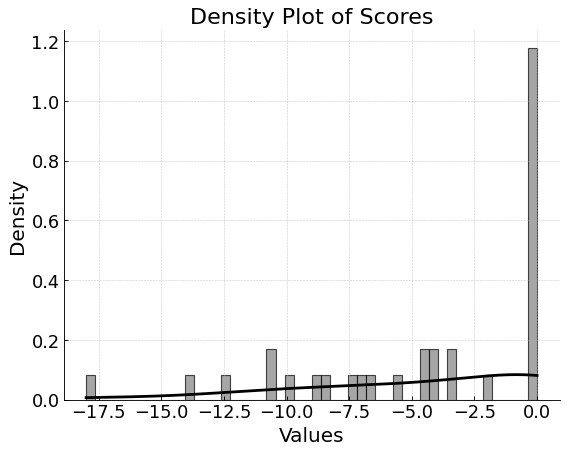

There are 14 ligands with 0 connections (42.4%)
There are 5 ligands with scores less than -10.0 (15.2%)
The mean score for all ligands is -4.4
The lowest score for all ligands is -18.0


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

data = list(sorted_ligands.values())

plt.figure(figsize=(8, 6), dpi=80)

plt.hist(data, bins=50, density=True, color='gray', alpha=0.7, edgecolor='black')

smoothed_data = np.linspace(min(data), max(data), 1000)
kde = gaussian_kde(data)
smoothed_line = kde(smoothed_data)

plt.plot(smoothed_data, smoothed_line, linewidth=2.5, color='black')

plt.xlabel("Values", fontsize=18)
plt.ylabel("Density", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title("Density Plot of Scores", fontsize=20)

plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tick_params(axis='both', which='both', direction='in', length=4)

plt.show()

print(f'There are {list(sorted_ligands.values()).count(0)} ligands with 0 connections ({np.round(list(sorted_ligands.values()).count(0) / len(sorted_ligands)*100, 1)}%)')
print(f'There are {len([value for value in list(sorted_ligands.values()) if value < -10.0])} ligands with scores less than -10.0 ({np.round(len([value for value in list(sorted_ligands.values()) if value < -10.0]) / len(sorted_ligands)*100, 1)}%)')
print(f'The mean score for all ligands is {np.round(np.mean(list(sorted_ligands.values())), 1)}')
print(f'The lowest score for all ligands is {np.min(list(sorted_ligands.values()))}')

In [ ]:
good_ligands = {key: value for key, value in sorted_ligands.items() if value != 0}

In [ ]:
good_idx = [k[7:] for k in good_ligands if k.startswith('complex')]

In [ ]:
import pandas as pd
diffdock_input = pd.read_csv('/content/drive/MyDrive/Generative_ML/current_data/mols_sampled_for_difdock_07_07.csv')

In [ ]:
good_data = diffdock_input.iloc[good_idx]

In [ ]:
good_data['score'] = [good_ligands.get(f'complex{complex_number}', 0) for complex_number in good_data.index]

<ipython-input-19-3e5ec29e2571>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_data['score'] = [good_ligands.get(f'complex{complex_number}', 0) for complex_number in good_data.index]


In [ ]:
good_data

,Unnamed: 0,smiles,cluster_id,score
3,3,CSc1nnc(SCC(=O)Nc2cc(C)cc(C)c2)s1,21,-18.0
29,29,CN(C(=O)COC(=O)CC12CC3CC(CC(C3)C1)C2)c1ccccc1,31,-14.0
0,0,CCn1cc(C(=O)NCC2C(=O)N=C(C)C=C2C)cn1,54,-12.5
4,4,CSc1nnc(SCC(=O)Nc2ccnn2C(C)C)s1,21,-10.5
27,27,CC1(C)CCC2(C)C(CC3CCC2C(O)C(N2CCOCC2)C3)N1,31,-10.5
7,7,CSc1nnc(SCC(=O)N(C)C(C)C)s1,21,-10.0
13,13,CCN1CCN(C2=NS(=O)(=O)c3ccccc32)CC1,92,-9.0
18,18,Nc1ccc2c(c1)N=C(Nc1ccc(F)cc1F)CO2,92,-8.5
32,32,C#CCN1CCN(CC=Cc2ccc(Cl)cc2)CC1=O,75,-7.5
17,17,CCN(C(=O)CCNC1=NS(=O)(=O)c2ccccc21)C1CC1,92,-7.0


## Prepare training dataset for next round of active learning

In [ ]:
cluster_to_scores = {}
for index, row in good_data.iterrows():
    cluster_to_scores.setdefault(row['cluster_id'], []).append(row['score'])
cluster_to_score = {cluster_id: np.mean(scores) for cluster_id, scores in cluster_to_scores.items()}
import random
cluster_to_score = {k: random.uniform(-20, 0) for k in range(50)}
print(cluster_to_score)

{0: -3.5737377362409006, 1: -8.718192248431691, 2: -1.008055413616347, 3: -0.17262907181792642, 4: -12.523850246754067, 5: -7.547771673957747, 6: -7.628253245643318, 7: -14.527801647759148, 8: -11.461913127296198, 9: -6.151128991058384, 10: -5.157594304580595, 11: -4.5162917941753555, 12: -14.443278978981928, 13: -3.300100778045149, 14: -0.06212197988290313, 15: -19.33983402983262, 16: -16.183523634152124, 17: -15.236976243081195, 18: -10.183579128555051, 19: -10.521743173056981, 20: -15.110941716166453, 21: -14.028069644127445, 22: -8.775790816747804, 23: -6.3572715143124565, 24: -1.583702380815165, 25: -6.4849547167075166, 26: -5.087021416627703, 27: -15.135958548287507, 28: -7.832652513644689, 29: -16.014180818241105, 30: -9.57682582787827, 31: -6.973395225398891, 32: -5.925609813801529, 33: -18.46974273617391, 34: -3.393362868448648, 35: -10.754453045853754, 36: -10.360957982345965, 37: -16.34269008463877, 38: -5.823249532349635, 39: -1.071095804441967, 40: -13.175421222580324, 41:

Here, we need to map the good data back to the original clusters and create a training set for active learning. THen, perform active learning, generate molecules, and repeat process. Finally, generate 2 million molecules to train BERT

In [ ]:
import pickle

def _preprocess_scores_uniformly(scores, remove_positives=False, lowest_score=1):
    """
        Preprocesses a dictionary of scores by negating and normalizing them.

        The function negates all scores and optionally removes positive scores. If the minimum value among the negated scores
        is less than zero, it shifts all values by subtracting the minimum value and adding 'lowest_score'. The final step is
        to normalize the scores so that their total sum equals to 1.

        Parameters
        ----------
        scores : dict
            A dictionary of scores where the keys are identifiers and the values are their corresponding scores.

        remove_positives : bool, optional (default=False)
            If True, all positive scores are removed after negation.

        lowest_score : int, optional (default=1)
            This value is added to all scores if the minimum score is less than zero.

        Returns
        -------
        normalized : dict
            The normalized dictionary of scores.

    """
    negated = {k: -v for k, v in scores.items()}
    min_value = min(negated.values())
    if min_value < 0:
        if remove_positives:
            negated = {k: v for k, v in negated.items() if v > 0}
        else:
            negated = {k: v - min_value + lowest_score for k, v in negated.items()}
    total = sum(negated.values())
    normalized = {k: v / total for k, v in negated.items()}
    return normalized

def _preprocess_scores_softmax(scores):
    negated = {k: -v for k, v in scores.items()}
    max_value = max(negated.values())
    exponentiate = {k: np.exp(v - max_value) for k, v in negated.items()}
    total = sum(exponentiate.values())
    softmax = {k: v / total for k, v in exponentiate.items()}
    return softmax

def balance_cluster_to_n(cluster_to_n, cluster_to_len):
    """
        Balances the target number of samples for each cluster to ensure it doesn't exceed the actual size of the cluster.

        The function first calculates the surplus (i.e., the excess of the target number over the actual size) for each cluster.
        Then, it distributes the total surplus proportionally among the clusters that have a deficit (i.e., the target number is less than the actual size).
        If after this distribution, there's still a deficit (i.e., the sum of target numbers is less than the sum of actual sizes), the function
        increases the target number of the largest clusters one by one until the sum of target numbers equals to the sum of actual sizes.

        Parameters
        ----------
        cluster_to_n : dict
            A dictionary mapping cluster identifiers to their target number of samples.

        cluster_to_len : dict
            A dictionary mapping cluster identifiers to the actual size of each cluster.

        Returns
        -------
        balanced : dict
            A dictionary mapping cluster identifiers to their balanced target number of samples.

        Raises
        ------
        AssertionError
            If the sum of target numbers before and after balancing don't match.

    """

    surplus = {key: cluster_to_n[key] - cluster_to_len[key] for key in cluster_to_n if cluster_to_n[key] > cluster_to_len[key]}
    balanced = {k:v for k, v in cluster_to_n.items()}
    n_to_cluster = {v: k for k, v in cluster_to_n.items()}

    for key in surplus:
        balanced[key] = cluster_to_len[key]

    total_surplus = sum(surplus.values())
    initial_n_sum = sum(n for key, n in cluster_to_n.items() if key not in surplus)

    for key in balanced:
        if key in surplus: continue
        surplus_to_add = total_surplus * cluster_to_n[key] / initial_n_sum
        new_n = int(cluster_to_n[key] + surplus_to_add)
        balanced[key] = min(new_n, cluster_to_len[key])

    deficit = sum(cluster_to_n.values()) - sum(balanced.values())
    while deficit > 0:
        for initial_n in sorted(n_to_cluster, reverse=True):
            if deficit == 0:
                break
            if (cluster:=n_to_cluster[initial_n]) in surplus: continue
            if balanced[cluster] < cluster_to_len[cluster]:
                balanced[cluster] += 1
                deficit -= 1

    assert sum(cluster_to_n.values()) == sum(balanced.values()), f"Before balancing had {sum(cluster_to_n.values())}, post balancing = {sum(balanced.values())}"
    return balanced

def sample_clusters_for_active_learning(cluster_to_scores, n_samples, path_to_clusters, probability_type='softmax', remove_positives=False, lowest_score=1):
    """
        Sample molecules from clusters for active learning purposes, considering previously docked molecules and balancing the sampling among clusters.

        This function uses either softmax or uniform probabilities to determine how many molecules to sample from each cluster. The function then samples
        the required number of new molecules (i.e., those not present in docked_mols) from each cluster. The sampling is balanced to ensure the target number
        doesn't exceed the actual size of the cluster.

        Parameters
        ----------
        cluster_to_scores : dict
            A dictionary mapping cluster identifiers to their scores.

        n_samples : int
            The total number of molecules to sample.

        path_to_clusters : str
            The path to a pickle file storing a dictionary that maps each cluster to a list of molecules.

        probability_type : str, optional (default='softmax')
            The type of probability distribution used to determine the number of samples per cluster.
            Options are 'softmax' and 'uniform'.

        remove_positives : bool, optional (default=False)
            Only used when probability_type is 'uniform'. If True, positive scores are removed after negation.

        lowest_score : int, optional (default=1)
            Only used when probability_type is 'uniform'. This value is added to all scores if the minimum score is less than zero.

        Returns
        -------
        training : list
            A list of randomly sampled molecules for active learning.

        Raises
        ------
        KeyError
            If an unsupported probability_type is provided.
        AssertionError
            If the number of sampled molecules doesn't equal to n_samples.

    """
    if probability_type == 'softmax':
        probability_function = _preprocess_scores_softmax
    elif probability_type == 'uniform':
        probability_function = lambda x: _preprocess_scores_uniformly(x, remove_positives, lowest_score)
    else:
        raise KeyError("Only uniform and softmax probabilities are supported")
    cluster_to_mols = pickle.load(open(path_to_clusters, 'rb'))
    cluster_to_samples = pickle.load(open(path_to_clusters.split('.')[0] + '_samples.pickle', 'rb'))
    docked_mols = {smile for smiles in cluster_to_samples.values() for smile in smiles}
    cluster_to_new_mols = {k: [smile for smile in v if smile not in docked_mols] for k, v in cluster_to_mols.items()}

    probabilities = probability_function(cluster_to_scores)
    cluster_to_n = {k: int(v * n_samples) for k, v in probabilities.items()}
    max_cluster_id, max_prob = None, 0
    for cluster, prob in probabilities.items():
        if prob > max_prob:
            max_cluster_id, max_prob = cluster, prob
    cluster_to_n[max_cluster_id] += n_samples - sum(cluster_to_n.values())

    cluster_to_len = {k: len(v) for k, v in cluster_to_new_mols.items()}
    balanced = balance_cluster_to_n(cluster_to_n, cluster_to_len)

    training = []
    for i, (cluster, n) in enumerate(balanced.items()):
        training.extend(random.sample(cluster_to_new_mols[cluster], n))
    assert len(training) == n_samples, f"{len(training)=} != {n_samples=}"
    return training

training_sampled = sample_clusters_for_active_learning(cluster_to_score, n_samples=1000, probability_type='uniform', path_to_clusters= '/content/drive/MyDrive/Generative_ML/current_data/cluster_to_samples_07_07.pickle')


In [ ]:
def combine_sampled_and_good_ligands(sampled, good_ligands, good_ligand_multiplier:int, save_path):
    # assert isinstance(good_ligand_multiplier, int), "A multiplier should be an integer"
    keyToData = {}
    for mol in sampled:
        keyToData.setdefault('smiles', []).append(mol)
    for mol in good_ligands:
        for _ in range(good_ligand_multiplier):
            keyToData.setdefault('smiles', []).append(mol)
    pd.DataFrame(keyToData).to_csv(save_path)


combine_sampled_and_good_ligands(training_sampled, good_ligands, good_ligand_multiplier=2, save_path='/content/drive/MyDrive/Generative_ML/current_data/active_learning_training.csv')
pd.read_csv('/content/drive/MyDrive/Generative_ML/current_data/active_learning_training.csv').shape

(1038, 2)

Now train and generate

#BERT

##Set up notebook

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# install necessary packages
!pip install rdkit
!pip install pandas==1.5.3
!pip install molsets
!pip install wandb

# clone Sophia optimizer GitHub repository
!git clone https://github.com/Liuhong99/Sophia.git

# import necessary packages
import numpy as np
import h5py
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, pairwise_distances
import os
import random
from scipy import stats
import matplotlib.pyplot as plt
import pkg_resources
pkg_resources.require("pandas==1.5.3")
import pandas as pd
import re
import math
import random
import logging
import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.cuda.amp import GradScaler
from rdkit import Chem
from rdkit.Chem import QED, Crippen
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
import moses
from moses.utils import get_mol
from Sophia.sophia import SophiaG
import yaml

# set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

##Utils & Dataset

In [ ]:
@torch.no_grad()
def sample(model, x, steps, temperature=1.0, prop=None, scaffold=None):
    block_size = model.get_block_size() # define size of context window used for input conditioning
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # limit conditioning input to the most recent block_size elements
        logits, _= model(x_cond, prop = prop, scaffold = scaffold) # give input to model and get logits (unnormalized scores or probabilities)
        logits = logits[:, -1, :] / temperature # extract the logits for the next token in the sequence
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, 1)
        x = torch.cat((x, ix), dim=1) # concatenate the chosen token index with the existing sequence
    return x



@torch.no_grad()
def fill_mask(model, x, temperature=1.0, prop=None, scaffold=None):
    block_size = model.get_block_size()  # Get model's maximum context length
    model.eval()

    # Check if mask token is present
    mask_index = model.config.mask_index  # Assuming 'mask_index' is available in your model's config
    while mask_index in x[0]:  # If mask token is present
        # Find all mask positions
        mask_positions = (x[0] == mask_index).nonzero(as_tuple=True)

        for pos in mask_positions:  # Iterate over each mask position
            # Limit conditioning input to the most recent block_size elements
            x_cond = x if x.size(1) <= block_size else x[:, -block_size:]
            # Get token probabilities
            logits, _ = model(x_cond, prop=prop, scaffold=scaffold)

            # Extract the logits for the masked token position, apply temperature and softmax to get probabilities
            logits = logits[0, pos, :] / temperature
            probs = F.softmax(logits, dim=-1)
            ix = torch.multinomial(probs, 1)  # Sample token from probability distribution

            x[0, pos] = ix  # Replace mask token with sampled token

    return x  # Return unmasked tensor

def check_novelty(gen_smiles, train_smiles):
    if len(gen_smiles) == 0:
        novel_ratio = 0
    else:
        duplicates = [1 for mol in gen_smiles if mol in train_smiles]
        novel = len(gen_smiles) - sum(duplicates)
        novel_ratio = novel*100/len(gen_smiles)
    return novel_ratio

def canonic_smiles(smiles_or_mol):
    mol = get_mol(smiles_or_mol)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

class SMILESDataset(Dataset):

    def __init__(self, data=None, content=None, block_size=None, prop=None, scaffold=None, scaffold_maxlen=None, len_data=None, mask_prob=0.15):
        if content is None:
            self.desc_only = True
            return
        self.desc_only = False
        self.chars = sorted(list(set(content)))
        data_size, vocab_size = len(content), len(self.chars)
        self.vocab_size = vocab_size

        self.stoi = {ch:i for i,ch in enumerate(self.chars)}
        self.itos = {i:ch for i,ch in enumerate(self.chars)}
        self.max_len = block_size
        self.data = data
        self.prop = prop
        self.sca = scaffold
        self.scaf_max_len = scaffold_maxlen
        self.len_data = len_data
        self.mask_prob = mask_prob

        # add X token to vocabulary
        self.stoi['X'] = len(self.stoi)
        self.itos[len(self.itos)] = 'X'
        self.vocab_size = len(self.stoi)

    def export_desc_attributes(self, export_path):
        attr_dict = {
            "desc_only": self.desc_only,
            "vocab_size": self.vocab_size,
            "max_len": self.max_len,
            "stoi": self.stoi,
            "itos": self.itos,
            "scaf_max_len": self.scaf_max_len,
            "len_data": self.len_data
        }
        with open(export_path, 'w') as f:
            yaml.dump(attr_dict, f)

    def load_desc_attributes(self, load_path):
        with open(load_path, 'r') as f:
            attr_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(attr_dict)

    def __len__(self):
        assert not self.desc_only, "Dataset is not initialized"
        return len(self.data)

    def __getitem__(self, idx):
        assert not self.desc_only, "Dataset is not initialized"
        smiles, prop, scaffold = self.data[idx].strip(), self.prop[idx], self.sca[idx]
        if scaffold:
          scaffold=scaffold.strip()
        pattern =  "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9]|X)"
        regex = re.compile(pattern)

        #tokenize input string
        tokens_arr=regex.findall(smiles)

        #Save ground truth encodings before token masking
        smiles_true = smiles+str('<')*(self.max_len - len(tokens_arr))
        if len(tokens_arr) > self.max_len:
            smiles_true = smiles[:self.max_len]
        dix_true=[self.stoi[s] for s in regex.findall(smiles_true)]



        # randomly replace tokens
        mask_idx = [] #True indicates that the corresponding position will be ignored for computing loss
        for s in range(len(tokens_arr)):
          if random.random() < .15:
            mask_idx.append(False)
            num = random.random()
            if num >= .2: # 80%
                tokens_arr[s]='X'
            elif num >= 0.1: # 10%
                tokens_arr[s] = self.chars[int(random.random()*len(self.chars))]
          else:
            mask_idx.append(True)

        #pad the mask appropriately
        while len(mask_idx)<self.max_len:
            mask_idx.append(True)

        assert len(mask_idx)==self.max_len
        smiles=''.join(tokens_arr)

        smiles += str('<')*(self.max_len - len(regex.findall(smiles)))
        if len(regex.findall(smiles)) > self.max_len:
            smiles = smiles[:self.max_len]

        assert len(''.join(regex.findall(smiles)))==len(smiles)
        smiles=regex.findall(smiles)


        dix =  [self.stoi[s] for s in smiles]
        if scaffold:
          scaffold += str('<')*(self.scaf_max_len - len(regex.findall(scaffold)))
          if len(regex.findall(scaffold)) > self.scaf_max_len:
              scaffold = scaffold[:self.scaf_max_len]
          scaffold=regex.findall(scaffold)
          sca_dix = [self.stoi[s] for s in scaffold]
          sca_tensor = torch.tensor(sca_dix, dtype=torch.long)
        else:
          sca_tensor=torch.tensor(scaffold,dtype=torch.bool)
        x = torch.tensor(dix, dtype=torch.long)
        y = torch.tensor(dix_true, dtype=torch.long)
        prop = torch.tensor([prop], dtype=torch.float)
        return x, y, prop, sca_tensor, torch.tensor(mask_idx)

##Model

In [ ]:
class GPTConfig:
    def __init__(self, vocab_size=None, block_size=None, mask_index=None, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.mask_index = mask_index
        for k,v in kwargs.items():
            setattr(self, k, v)

    def export_attributes(self, export_path):
        with open(export_path, 'w') as f:
            yaml.dump(vars(self), f)

    def load_attributes(self, load_path):
        with open(load_path, 'r') as f:
            config_dict = yaml.load(f, Loader=yaml.SafeLoader)
        self.__dict__.update(config_dict)

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embed % config.n_head == 0
        self.config = config

        self.query = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.key = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)
        self.value = nn.Linear(config.n_embed, config.n_embed, bias=config.att_bias)

        self.attn_drop = nn.Dropout(config.att_drop_rate)
        self.resid_drop = nn.Dropout(config.att_drop_rate)

        self.proj = nn.Linear(config.n_embed, config.n_embed)
        self.n_head = config.n_head

        num = int(bool(config.num_props)) + int(config.scaffold_maxlen)
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size + num, config.block_size + num))
                                .view(1, 1, config.block_size + num, config.block_size + num))

    def forward(self, x, layer_past=None):
        B, T, C = x.size()
        # apply attention functions to get tensors with dimensions (B, n_head, T, head_size)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head)
        k = self.key(x).view(B, T, self.n_head, C // self.n_head)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head)
        if self.config.do_flash:
            q = q.transpose(1, 2)
            k = k.transpose(1, 2)
            v = v.transpose(1, 2)
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, dropout_p=self.config.att_drop_rate if self.training else 0, is_causal=self.config.is_causal)
            y = y.transpose(1, 2)
        else:
            # (B h T s) @ (B h s T) -> (B h T T)
            att = torch.einsum('bths,bihs->bhti', q, k) / math.sqrt(k.size(-1))
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            # (B h T T) @ (B h T s) -> (B h T s)
            y = torch.einsum('bhtq,bqhs->bths', att, v)
            self.att_weights = att
        self.attended = y
        y = y.contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        self.out = y
        return y

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embed)
        self.ln2 = nn.LayerNorm(config.n_embed)
        self.attn = SelfAttention(config)
        self.mlp = nn.Sequential(nn.Linear(config.n_embed, config.ff_mult*config.n_embed), nn.GELU() if config.doGELU else nn.ReLU(),
            nn.Linear(config.ff_mult*config.n_embed, config.n_embed), nn.Dropout(config.att_drop_rate))

    def forward(self, x):
        y = self.attn(self.ln1(x))
        x = x + y # perform a residual connection by summing input and attention output
        x = x + self.mlp(self.ln2(x)) # apply layer normalization and then MLP, create a residual connection with input
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embed)
        self.type_emb = nn.Embedding(2, config.n_embed)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embed))
        # if conditioning on at least 1 property:
        if config.num_props:
            # initialize property linear layer, map property vector to embedding dimension
            self.prop_nn = nn.Linear(config.num_props, config.n_embed)

        self.drop = nn.Dropout(config.gpt_drop_rate)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])

        self.ln_f = nn.LayerNorm(config.n_embed)
        self.head = nn.Linear(config.n_embed, config.vocab_size, bias=config.gpt_bias)
        self.block_size = config.block_size # define the context size
        self.apply(self._init_weights) # initialize weights and apply to all relevant modules in the model

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        decay, no_decay = set(), set()
        no_decay = set()

        whitelist_weight_modules = (torch.nn.Linear)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        # for named module of the model:
        for mn, m in self.named_modules():
            # for named parameter of each module:
            for pn, p in m.named_parameters():
                # construct full parameter name by concatenating module name and parameter name, separated by a dot
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias') or ('bias' in pn):
                    no_decay.add(fpn)
                elif (pn.endswith('weight') or ('weight' in pn)) and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        no_decay.add('pos_emb')
        param_dict = {pn:p for pn, p in self.named_parameters()}
        assert len(decay & no_decay) == 0
        # assert that all parameters from both sets have been correctly separated
        assert len(param_dict.keys() - (decay | no_decay)) == 0
        optim_groups = [{"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}]
        optimizer = SophiaG(optim_groups, lr=train_config.learning_rate, betas=train_config.betas, rho=train_config.rho, weight_decay=train_config.weight_decay)
        return optimizer

    def forward(self, idx, targets=None, prop=None, scaffold=None):
        b, t = idx.size()
        assert t <= self.block_size
        if self.config.num_props:
            assert prop.size(-1) == self.config.num_props, f"number of properties {prop.size(-1)=} doesn't match the expected size {self.config.num_props=}"
        token_embeddings = self.tok_emb(idx)
        position_embeddings = self.pos_emb[:, :t, :]
        type_embeddings = self.type_emb(torch.ones((b,t), dtype=torch.long, device=idx.device))
        x = self.drop(token_embeddings + position_embeddings + type_embeddings)
        # Condition on properties
        if self.config.num_props:
            type_embd = self.type_emb(torch.zeros((b, 1), dtype=torch.long, device=idx.device))
            if prop.ndim == 2:
                p = self.prop_nn(prop.unsqueeze(1))
            else:
                p = self.prop_nn(prop)
            p += type_embd
            x = torch.cat([p, x], 1)
        # Condition on scaffold
        if self.config.scaffold:
            type_embd = self.type_emb(torch.zeros((b, 1), dtype = torch.long, device = idx.device))
            scaffold_embeds = self.tok_emb(scaffold)
            scaffold_embeds += type_embd
            x = torch.cat([scaffold_embeds, x], 1)

        # Transformer blocks
        for layer in self.blocks:
            x = layer(x)
        x = self.ln_f(x)
        logits = self.head(x)

        if self.config.num_props and self.config.scaffold:
            num = int(bool(self.config.num_props)) + int(self.config.scaffold_maxlen)
        elif self.config.num_props:
            num = int(bool(self.config.num_props))
        elif self.config.scaffold:
            num = int(self.config.scaffold_maxlen)
        else:
            num = 0
        # Slice the logits tensor along the second dimension to exclude the first num elements
        logits = logits[:, num:, :]

        return logits

##Training

In [ ]:
class TrainerConfig:
    epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.965, 0.99) #(0.9, 0.95)
    rho = 0.04 # For SophiaG
    weight_decay = 0.1

    lr_decay = False
    warmup_tokens = 375e6 # number of warm-up tokens for learning rate decay
    final_tokens = 260e9 # number of tokens at which the learning rate decays to 10% of the original
    num_workers = 0 # number of worker processes to use for loading data

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

def loss_function(logits, y, mask_idx):
    loss=nn.CrossEntropyLoss(ignore_index=-1)
    y[mask_idx]=-1
    return loss(logits.view(-1,logits.size(-1)),y.view(-1))

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config, stoi, itos):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        self.stoi = stoi
        self.itos = itos
        self.model = self.model.to(config.device)

    def train(self, wandb):
        model, config = self.model, self.config
        optimizer = model.configure_optimizers(config)
        scaler = GradScaler() # define variable used for gradient scaling in mixed-precision training
        self.tokens = 0 # initialize a counter used for learning rate decay

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True, batch_size=config.batch_size, num_workers=config.num_workers)
            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            # for batch index, batch in progress bar:
            for it, (x, y, p, scaffold, mask_idx) in pbar:
                # move the input data tensor, target data tensor, property tensor, and scaffold tensor to GPU
                x, y, p, scaffold , mask_idx = x.to(config.device), y.to(config.device), p.to(config.device), scaffold.to(config.device), mask_idx.to(config.device)
                # allow model to use lower-precision computations for improved memory usage
                if config.device == 'cuda':
                    with torch.cuda.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits= model(x, y, p, scaffold)
                            loss = loss_function(logits, y, mask_idx)
                            loss = loss.mean()
                            losses.append(loss.item())
                else:
                    with torch.cpu.amp.autocast():
                        with torch.set_grad_enabled(is_train):
                            logits = model(x, y, p, scaffold)
                            loss = loss_function(x, y, mask_idx)
                            loss = loss.mean()
                            losses.append(loss.item())

                if is_train:
                    model.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer) # unscale the gradients of the optimizer's parameters to their original values
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients of model parameters to prevent them from exploding, setting maximum gradient norm to be 1.0
                    scaler.step(optimizer) # update the optimizer's parameters based on calculated gradients
                    scaler.update() # update the scale factor of the gradient scaler
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # increment the number of processed tokens by the count of valid tokens (not padding or special tokens)
                        if self.tokens < config.warmup_tokens:
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens)) # perform a linear warm-up
                        else:
                            # calculate the progress of training in terms of the number of tokens processed
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            # calculate the scaling factor for the learning rate (between 0.1 and 1.0)
                            # to gradually reduce learning rate as training progresses
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult # multiply the base learning rate by the scaling factor to obtain the updated learning rate
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate
                    # log training progress using Weights & Biases
                    if wandb is not None:
                        wandb.log({'step_train_loss': loss, 'train_step': it + epoch*len(loader), 'learning_rate': lr})
                    # update the description of the progress bar with epoch, iteration, and training loss
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")
            return float(np.mean(losses))


        # initialize best loss as infinity
        best_loss = float('inf')
        for epoch in range(config.epochs):
            print(f'{epoch=}')
            train_loss = run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')
            if wandb is not None:
                wandb.log({'epoch_valid_loss': test_loss, 'epoch_train_loss': train_loss, 'epoch': epoch + 1})
            good_model = self.test_dataset is None or test_loss < best_loss
            if good_model:
                best_loss = test_loss
                torch.save(self.model.state_dict(), self.config.ckpt_path)

In [ ]:
def load_data(train_config_dict):
    if (cut:=train_config_dict["slice_data"]):
        train_data = pd.read_csv(train_config_dict["train_path"])[:cut]
        val_data = pd.read_csv(train_config_dict["val_path"])[:cut]
    else:
        train_data = pd.read_csv(train_config_dict["train_path"])
        val_data = pd.read_csv(train_config_dict["val_path"])

    smiles = train_data['smiles']
    vsmiles = val_data['smiles']

    prop = train_data[train_config_dict["props"]].values.tolist()
    vprop = val_data[train_config_dict["props"]].values.tolist()

    scaffold = train_data['scaffold_smiles']
    vscaffold = val_data['scaffold_smiles']

    # define a regular expression that matches molecular tokens in SMILES strings
    pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9]|X)"
    # compile pattern into a regular expression object that can be used for matching operations
    regex = re.compile(pattern)

    context = {'<'}

    max_len, scaffold_max_len = 0, 0
    for iterator in (smiles.values, vsmiles.values):
        for i in iterator:
            chars = regex.findall(i.strip())
            max_len = max(max_len, len(chars))
            for char in chars:
                context.add(char)
    for iterator in (scaffold.values, vscaffold.values):
        for i in iterator:
            chars = regex.findall(i.strip())
            scaffold_max_len = max(scaffold_max_len, len(chars))
            for char in chars:
                context.add(char)
    print(max_len)
    context = sorted(list(context))

    smiles = [i + str('<')*(max_len - len(regex.findall(i.strip()))) for i in smiles]
    vsmiles = [i + str('<')*(max_len - len(regex.findall(i.strip()))) for i in vsmiles]
    scaffold = [i + str('<')*(scaffold_max_len - len(regex.findall(i.strip()))) for i in scaffold]
    vscaffold = [i + str('<')*(scaffold_max_len - len(regex.findall(i.strip()))) for i in vscaffold]

    # if not conditioning on scaffolds: define 'scaffold' as a list of length SMILES string filled with 'False' values
    scaffold=[False]*len(smiles) if not train_config_dict["use_scaf"] else scaffold
    train_dataset = SMILESDataset(smiles, context, max_len, prop=prop, scaffold=scaffold, scaffold_maxlen=scaffold_max_len, len_data=len(train_data), mask_prob=0.15)
    valid_dataset = SMILESDataset(vsmiles, context, max_len, prop=vprop, scaffold=vscaffold, scaffold_maxlen=scaffold_max_len, len_data=len(val_data), mask_prob=0.15)
    train_dataset.export_desc_attributes(train_config_dict["desc_path"])
    return train_dataset, valid_dataset

In [ ]:
def pretrain_BERT(train_dataset, valid_dataset, model_config_dict, train_config_dict):
  """
  OUTPUTS:
  1) checkpoint of trained model parameters
  2) Weights & Biases logged run
  """

  mask_index = train_dataset.stoi['X']
  mconf = GPTConfig(train_dataset.vocab_size, train_dataset.max_len, mask_index=mask_index, num_props=len(train_config_dict["props"]), scaffold=train_config_dict["use_scaf"], scaffold_maxlen=train_dataset.scaf_max_len, **model_config_dict)
  model = GPT(mconf).to(model_config_dict["device"])

  if train_config_dict['load_cpt'] != None:
    model.load_state_dict(torch.load(train_config_dict['load_cpt']))
  torch.compile(model)

  tconf = TrainerConfig(warmup_tokens=0.1*train_dataset.len_data*train_dataset.max_len, final_tokens=train_config_dict["epochs"]*train_dataset.len_data*train_dataset.max_len, block_size=train_dataset.max_len, **train_config_dict)
  trainer = Trainer(model, train_dataset, valid_dataset, tconf, train_dataset.stoi, train_dataset.itos)

  %env WANDB_EXECUTABLE=python3
  wandb.init(project="mol_transformer", name=train_config_dict["wandb_runname"])
  trainer.train(wandb=wandb)
  return model, tconf

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
BASE = '/content/drive/MyDrive/Generative_ML/'

model_config_dict = {
    "device": DEVICE,
    "att_bias": False,
    "gpt_bias": True,
    "att_drop_rate": 0.1,
    "gpt_drop_rate": 0.1,
    "n_layer": 8,
    "n_head": 8,
    "n_embed": 256,
    "ff_mult": 4, # multiplier for FF inside multihead,
    "doGELU": True, # else ReLU
    "attention_times": [],
    "do_flash": True,
    "is_causal": False
}

train_config_dict = {
    "desc_path": BASE + 'checkpoints/descriptors_10k.yaml',
    "train_path": BASE + 'data/MOSES_processed_train.csv',
    "val_path": BASE + 'data/MOSES_processed_val.csv',
    "slice_data": False,
    "ckpt_path": BASE + 'checkpoints/7-03_all_mask.pt',
    "wandb_runname": "7_03_all_mask",
    "use_scaf": False,
    "props": [],
    "device": DEVICE,
    "epochs": 10,
    "batch_size": 512,
    "lr_decay": True,
    "num_workers": 0,
    "load_cpt": None
}

In [ ]:
train_dataset, val_dataset = load_data(train_config_dict)

54


In [ ]:
# define function to train BERT model
model, tconf = pretrain_BERT(
                train_dataset = train_dataset,
                valid_dataset = val_dataset,
                model_config_dict = model_config_dict,
                train_config_dict = train_config_dict
        )

#GK wandb API Key: c99c9a01523f93287716691fa3360b1f4566e115
#RB wandb API Key: 4d3d628c6b5a4b3554c7a89ea50df8a4a6be0f85

##Generation & Evaluation

In [ ]:
def generate_SMILES(model_config_dict, inference_config_dict):
  props = inference_config_dict["props"]
  scaffold = inference_config_dict["scaffold"]

  # define a regular expression that matches molecular tokens in SMILES strings
  pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9]|X)"
  regex = re.compile(pattern)

  dataset = SMILESDataset()
  dataset.load_desc_attributes(inference_config_dict['desc_path'])
  use_scaf = False if scaffold is None else True

  mconf = GPTConfig(dataset.vocab_size, dataset.max_len, num_props=len(props), scaffold=use_scaf, scaffold_maxlen=dataset.scaf_max_len, **model_config_dict)
  model = GPT(mconf).to(model_config_dict['device'])
  torch.compile(model)

  # load parameters into the model
  model.load_state_dict(torch.load(inference_config_dict["model_params"], map_location=torch.device(model_config_dict['device'])))
  block_size = model.get_block_size() #inference_config_dict["block_size"]
  assert block_size == dataset.max_len, "Warning: model block size and dataset block size are different"
  # calculate number of generation iterations from total number of SMILES to generate and batch size
  gen_iter = math.ceil(inference_config_dict["gen_size"] / inference_config_dict["batch_size"])
  stoi = dataset.stoi # define dictionary to map strings to integers
  itos = dataset.itos # define dictionary to map integers to strings
  # is a scaffold is defined for conditioning:
  if scaffold is not None:
      # pad '<' to end of scaffold string to achieve maximum scaffold length
      scaffold += str('<')*(dataset.scaf_max_len - len(regex.findall(scaffold)))
      # convert the scaffold SMILES to a tensor of integers and repeat along the batch dimension, move to GPU
      scaffold=torch.tensor([stoi[s] for s in regex.findall(scaffold)])[None,...].repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])

  if props is None:
    p = None
  elif len(props) == 1:
    # create a tensor for conditioning with a single property value
    p = torch.tensor([[props[0]]]).repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])
  else:
    # create a tensor for conditioning with multiple property values
    p = torch.tensor([props]).repeat(inference_config_dict["batch_size"], 1).unsqueeze(1).to(model_config_dict['device'])

  molecules = []
  for i in tqdm(range(gen_iter)):
          # create an input tensor by converting 'context' to a tensor of token indices,
          # repeat this batch times along the batch dimension
          x = torch.tensor([stoi[s] for s in regex.findall(inference_config_dict["context"])], dtype=torch.long)[None,...].repeat(inference_config_dict["batch_size"], 1).to(model_config_dict['device'])

          if ['X'] in inference_config_dict['context']:
            # call sample function to generate molecules conditioned on the input
            y = fill_mask(model, x, block_size, temperature=inference_config_dict["temp"], prop=p, scaffold=scaffold)
          else:
            y = sample(model, x, block_size, temperature=inference_config_dict["temp"], prop=p, scaffold=scaffold)

          # for each generated molecule:
          for gen_mol in y:
                  # convert generated molecule from list of integers to list of strings and concatenate to one string
                  completion = ''.join([itos[int(i)] for i in gen_mol])
                  # remove padding tokens
                  completion = completion.replace('<', '')
                  # convert the string representation of the molecule to an rdkit Mol object
                  mol = get_mol(completion)
                  # if an rdkit Mol object was created:
                  if mol:
                          # append the Mol object to the list
                          molecules.append(mol)
  # create dataframe where first column contains rdkit Mols and second column contins SMILES
  results = pd.DataFrame([{'molecule' : i, 'smiles': Chem.MolToSmiles(i)} for i in molecules])
  # iterate over each SMILES and ensure that equivalent molecules have same SMILES
  canon_smiles = [canonic_smiles(s) for s in results['smiles']]
  # create set of unique SMILES strings
  unique_smiles = list(set(canon_smiles))
  data = pd.read_csv(inference_config_dict["train_data"]) # load training data
  novel_ratio = check_novelty(unique_smiles, set(data['smiles'])) # calculate novelty ratio from generated SMILES and training SMILES
  results['qed'] = results['molecule'].apply(lambda x: QED.qed(x)) # quantitative estimate of drug-likeliness (QED)
  results['sas'] = results['molecule'].apply(lambda x: sascorer.calculateScore(x)) #synthetic accessibility score (SAS)
  results['logp'] = results['molecule'].apply(lambda x: Crippen.MolLogP(x)) #(measure of hydrophobicity)
  results['tpsa'] = results['molecule'].apply(lambda x: CalcTPSA(x)) #topological polar surface area (TPSA)
  results['validity'] = np.round(len(results)/(inference_config_dict["batch_size"]*gen_iter), 3)
  results['unique'] = np.round(len(unique_smiles)/len(results), 3)
  results['novelty'] = np.round(novel_ratio/100, 3)
  # save the dataframe as a csv file
  results.to_csv(inference_config_dict["save_path"], index = False)
  # print all evaluation metrics using function from moses package
  print(moses.get_all_metrics(list(results['smiles'].values), device=model_config_dict['device']))

In [ ]:
inference_config_dict = {
    # "model_params": train_config_dict["ckpt_path"],
    "model_params": BASE + 'checkpoints/test_6_21.pt',
    "train_data": train_config_dict["train_path"],
    # "desc_path": model_config_dict["desc_path"],
    "desc_path": BASE + 'checkpoints/descriptors_200k.yaml',
    "save_path": BASE + 'data/test_06_21_t.csv',
    "batch_size": 1,
    "gen_size": 10,
    "temp": 1,
    "context": "C1CCXCCC1",
    "scaffold": None,
    "props": []
}

In [ ]:
# run function to generate SMILES strings
generate_SMILES(
              model_config_dict = model_config_dict,
              inference_config_dict = inference_config_dict
              )